In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Fetch data
url = "http://127.0.0.1:8000/api/v1/data/?table_name=precios_materiales&limit=1000"
try:
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    print(f"✓ Successfully fetched {len(data['data'])} records")
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
    raise
# Convert to Data Frame
df = pd.DataFrame(data['data'])

#Convert date to date of Dataframe
df['date'] = pd.to_datetime(df['date'])

#Variable a analizar 
var_analizar = 'scrap_mxn'
 



✓ Successfully fetched 190 records


En este ejemplo analizare la serie de tiempo del precio de la varilla del distribuidor


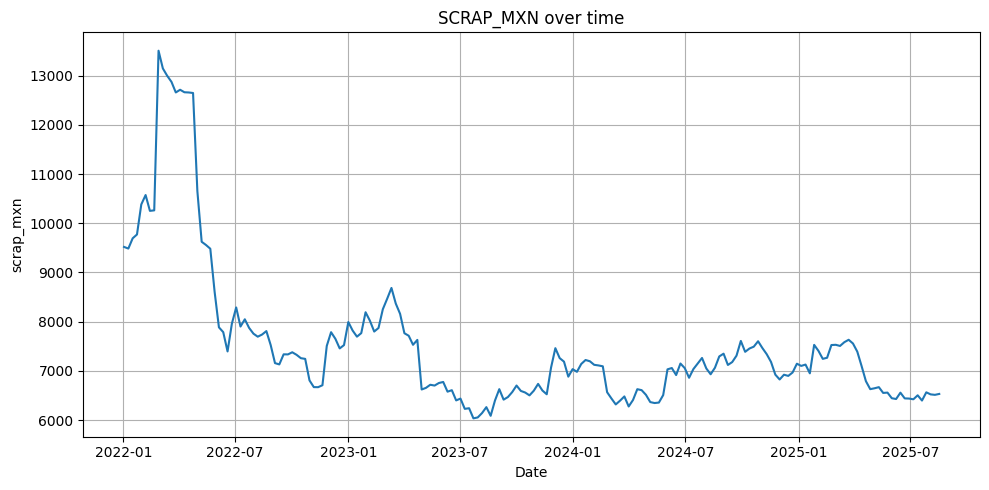

In [22]:
serie = df[var_analizar]

# Plot with date on x-axis
plt.figure(figsize=(10, 5))
plt.plot(df['date'], serie, linestyle='-')
plt.title(f"{var_analizar.upper()} over time")
plt.xlabel("Date")
plt.ylabel(var_analizar)
plt.grid(True)
plt.tight_layout()
plt.show()



Analisis visual del precio de la chatarra, pronunciado en lso primeros periodos, alcanzando aproximadamente $647 dolares, o en tipo de cambio de ~13,200 alrededor de febrero y marzo. Este pico coincide temporalmente con el de la varilla que voy a mostrar despues, lo cual tiene sentido ya que el scrap es la materia prima principal de la varilla.

Caida pronunciada: Desde el pico de ~645dlls, hay uan caida dramatica aproximada de $350 hsta finales de 2022, representando una disminucion del 45%, ESta caida tambien es paralela a la varilla


Tendencia
Veo una tendencia descendente despues de esta caida, hasta un periordo de finales del 2022 hasta mediados del 2023, y despues una tendencia ligeramente descendente adicional hasta el precio de los $340-$350


Estacionalidad
No observo un patron claro estacional claro en el grafico, el precio del scrap no muestra ciclos regulares anuales predecibles visualmente.


Volatilidad
Alta volatitilidad: 2022
Volatilidad moderada 2023
Baja volatilidad de 2024 en adelante



Paso 1: Verificar estacionariedad

In [23]:
from statsmodels.tsa.stattools import adfuller
#https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller

def check_stationarity(series):
    # referencia from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [24]:

check_stationarity(serie)

ADF Statistic: -4.420652
p-value: 0.000273
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575
Stationary


Que esta pasando aqui?
Visualmente la serie no es estacionaria, lo cual confunde
El test ADF, no prueba si la serie es completamente estacionaria, Especificamene prueba

p-value 0.001361 < 0.05 Rechaza h0
ADF -4.009531 < 5%: -2.878

Esto significa que la serie No es un radom walk.

Pero esto NO significa que sea estacionaria.

ADF puede dar estacionariedad, en series visuales que no lo son porque:

1. La seria de la chatarra, aunque tiene cambios de nivel, eventualmente regresa y no se va al infinito.

2. Aunque tengo cambios de nivel, ADF solo considera que no crece indefinidamente.


No es estacionaria en el sentido estricto, ya que la media y varianza no son constantes.

In [ ]:
#KPSS TEST

from statsmodels.tsa.stattools import kpss
#Doc https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html

def kpss_test(series):
    statistic, p_value, n_lags, critical_values = kpss(series, regression='c')
    #regression c estacionariedad alrededor de la constante
    #regression ct estacionariedad alrededor de la constante y tendencia
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'\t{key}: {value}')
    
    # En KPSS, H0 es que ES estacionaria
    if p_value < 0.05:
        print("\x1b[31mNon-stationary\x1b[0m")
    else:
        print("\u001b[32mStationary\u001b[0m")


In [26]:
kpss_test(serie)

KPSS Statistic: 0.8399751019999164
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Non-stationary


/var/folders/85/n4g_j3s15b137c5r7cyc_z200000gn/T/ipykernel_79822/1680746086.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, regression='c')


La prueba KPSS se utiliza para evaluar si una serie de tiempo es estacionaria alrededor de una media o tendencia. 
A diferencia de la prueba ADF, la KPSS tiene un planteamiento inverso en sus hipótesis, lo que la convierte en un complemento ideal para confirmar resultados.

Hipótesis de la prueba

H0 (hipótesis nula): La serie es estacionaria.

H1 (hipótesis alternativa): La serie es no estacionaria (es decir, presenta raíz unitaria o tiene tendencia estocástica).

combinando ADF + KPSS 



Paso 2: Revisar ACF y PACF
Esto nos dira que modelo conviene

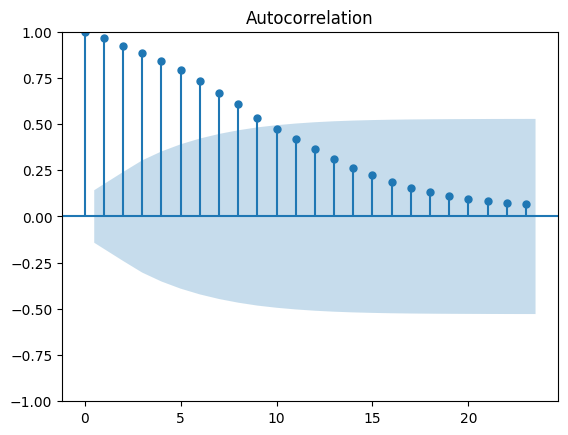

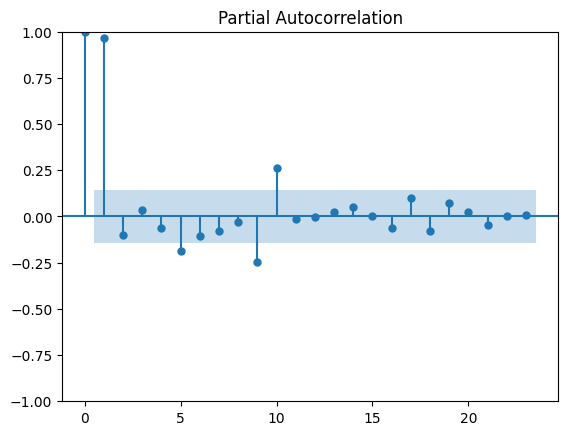

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(serie)
plot_pacf(serie)
plt.show()

Al analizar ACF, se ve que decae lentamente, eso quiere decir que hay una tendencia, y se sugiere AR


En PACF veo un pico en el lag 1, y ahi corte la serie seguido lo de ahi oscila en la banda de confianza
Lo que se sugiere un AR(1)


AIC y BIC en modelos ARIMA

1. ¿Qué son?
Son criterios de información que miden qué tan bien se ajusta un modelo a los datos, penalizando la complejidad del modelo (número de parámetros).

AIC (Akaike Information Criterion)
Evalúa el equilibrio entre el ajuste del modelo y su complejidad.

AIC=2k−2ln(L)

donde:

k = número de parámetros del modelo
L = verosimilitud (likelihood) del modelo

BIC (Bayesian Information Criterion)
Similar al AIC, pero penaliza más fuertemente los modelos con muchos parámetros.

BIC=kln(n)−2ln(L)

donde n = número de observaciones.

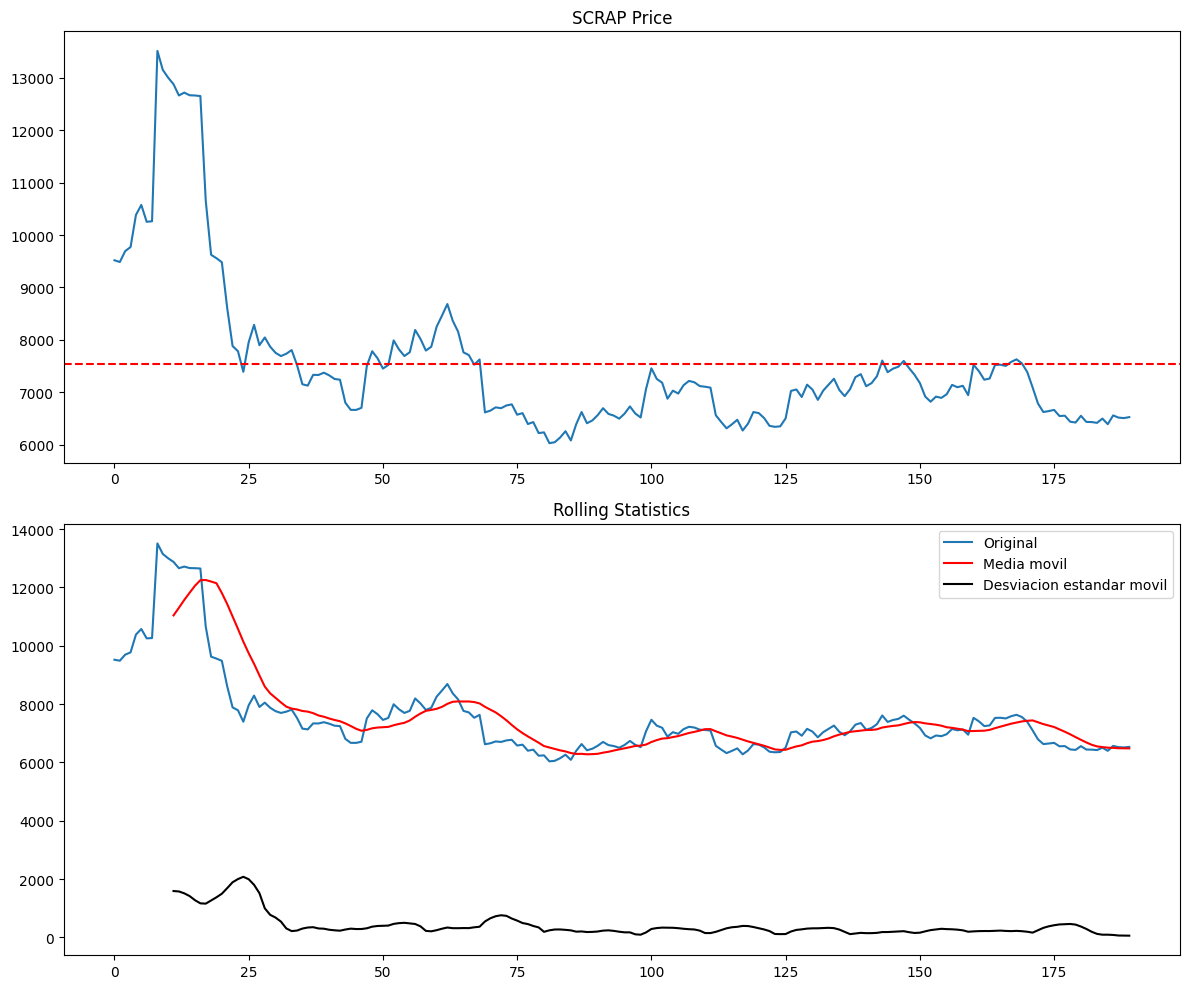

In [ ]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Serie original
axes[0].plot(serie)
axes[0].set_title('SCRAP Price')
axes[0].axhline(y=serie.mean(), color='r', linestyle='--', label='Mean')


rolling_mean = serie.rolling(window=12).mean() # media movil 
rolling_std = serie.rolling(window=12).std() #desviacion estandar movil

axes[1].plot(serie, label='Original')
axes[1].plot(rolling_mean, label='Media movil', color='red')
axes[1].plot(rolling_std, label='Desviacion estandar movil', color='black')
axes[1].legend()
axes[1].set_title('Rolling Statistics')


plt.tight_layout()
plt.show()

ADF Statistic: -6.451471
p-value: 0.000000
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575
Stationary
KPSS Statistic: 0.06104522430912385
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Stationary


/var/folders/85/n4g_j3s15b137c5r7cyc_z200000gn/T/ipykernel_79822/1680746086.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, regression='c')


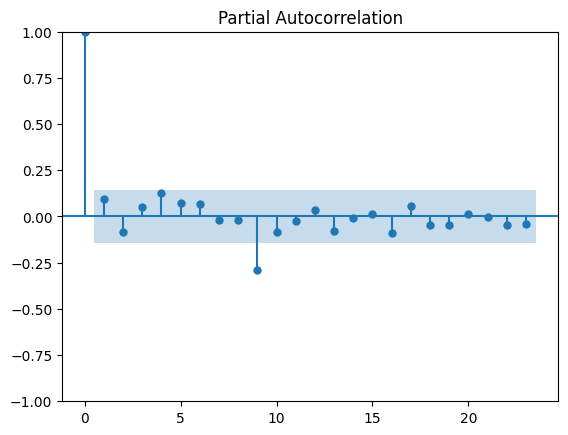

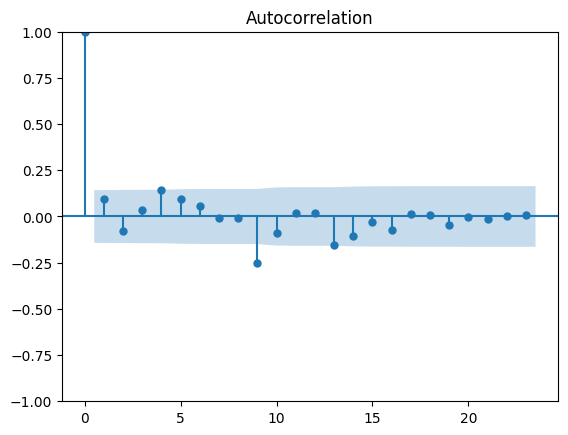

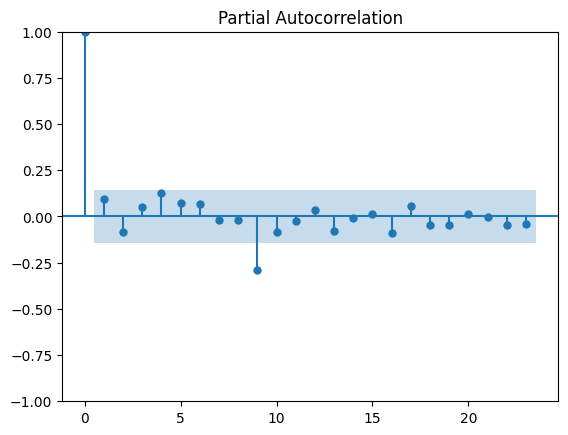

In [44]:
# Primera diferencia
scrap_diff = serie.diff().dropna()
check_stationarity(scrap_diff)
kpss_test(scrap_diff)

plot_acf(scrap_diff)
plot_pacf(scrap_diff)


In [46]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

train_serie, test_serie = train_test_split(serie, test_size=0.1, shuffle=False)

#Autoregresivo orden 1 , 1 diferencia, 0 media movil
modelo = ARIMA(train_serie, order=(1, 1,0))
fitted = modelo.fit()

pred = fitted.forecast(steps=len(test_serie))



#Autoregresivo orden 1
modelo_ma = ARIMA(train_serie, order=(1, 1,1))
resultado_ma = modelo.fit()

print(resultado_ma.summary())


                               SARIMAX Results                                
Dep. Variable:              scrap_mxn   No. Observations:                  171
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1252.067
Date:                Mon, 08 Dec 2025   AIC                           2508.133
Time:                        23:04:43   BIC                           2514.405
Sample:                             0   HQIC                          2510.678
                                - 171                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0841      0.052      1.608      0.108      -0.018       0.187
sigma2      1.469e+05   3834.086     38.309      0.000    1.39e+05    1.54e+05
Ljung-Box (L1) (Q):                   0.03   Jarque-

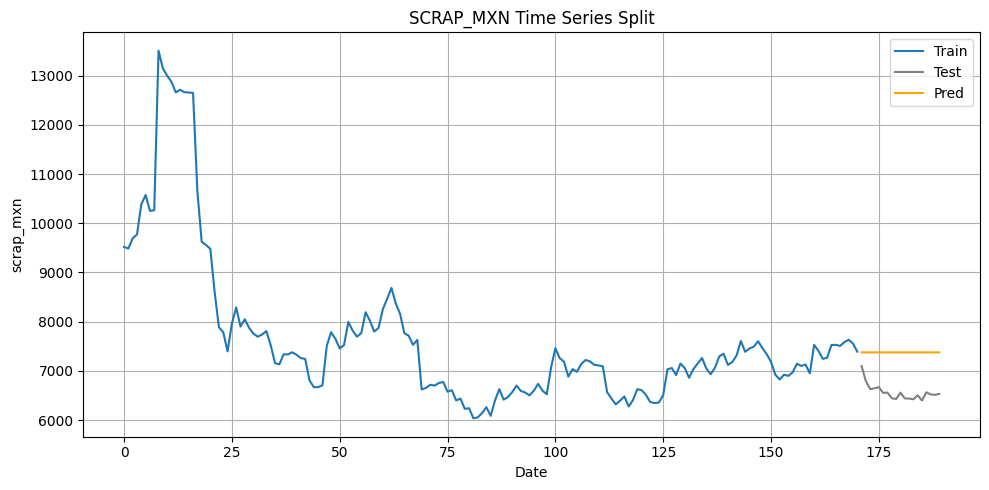

In [47]:

# Plot with date on x-axis
plt.figure(figsize=(10, 5))
plt.plot(train_serie.index, train_serie, label="Train")
plt.plot(test_serie.index, test_serie, label="Test", color="gray")

# Plot predictions
plt.plot(test_serie.index, pred, label="Pred", color="orange")

plt.legend()
plt.title(f"{var_analizar.upper()} Time Series Split")
plt.xlabel("Date")
plt.ylabel(var_analizar)
plt.grid(True)
plt.tight_layout()
plt.show()


In [60]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
train_serie, test_serie = train_test_split(serie, test_size=0.2, shuffle=False)

best_aic = float('inf')
best_bic = float('inf')
best_aic_order = None
best_bic_order = None

for p in range(3):  # Adjust the range as needed (p from 0 to 2)
    for d in range(2):  # d from 0 to 1
        for q in range(6):  # Adjust the range as needed (q from 0 to 6)
            try:
                model = ARIMA(train_serie, order=(p, d, q))  #order=(p, d, q)
                fitted_model = model.fit()
                
                # Check for AIC manually
                #AIC=2k−2ln(L) 
                log_likelihood = fitted_model.llf
                num_params = p + d + q + (1 if d != 0 else 0)  # Include constant term if d != 0

                aic = 2 * num_params - 2 * log_likelihood

                
                # Check for BIC manually
                #BIC=kln(n)−2ln(L)
                n = len(train_serie)
                bic = num_params * np.log(n) - 2 * log_likelihood

                # Check for AIC
                if aic < best_aic:
                    best_aic = aic
                    best_aic_order = (p, d, q)

                # Check for BIC
                if bic < best_bic:
                    best_bic = bic
                    best_bic_order = (p, d, q)


                #Orden con fitted_model
                # if fitted_model.aic < best_aic:
                #     best_aic = fitted_model.aic
                #     best_aic_order = (p, d, q)


                # if fitted_model.bic < best_bic:
                #     best_bic = fitted_model.bic
                #     best_bic_order = (p, d, q)

                

            except Exception as e:
                print(f"Error with order {(p, d, q)}: {e}")

print("Best AIC Order:", best_aic_order, "with AIC:", best_aic)
print("Best BIC Order:", best_bic_order, "with BIC:", best_bic)

best_aic = best_aic_order
best_bic = best_bic_order

/Users/alangarcia/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alangarcia/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alangarcia/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alangarcia/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

Best AIC Order: (2, 1, 3) with AIC: 2241.8623595814884
Best BIC Order: (0, 1, 0) with BIC: 2249.830715867522


/Users/alangarcia/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 3)


/Users/alangarcia/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


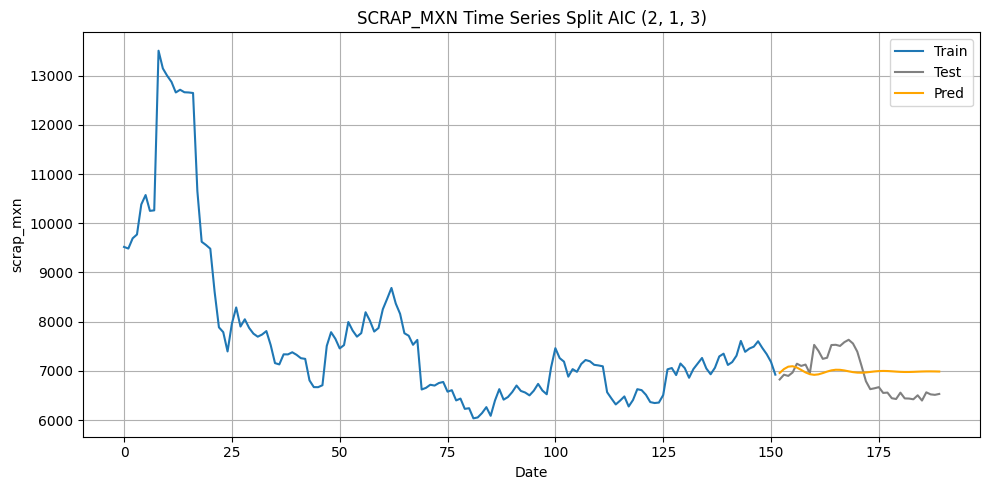

In [66]:

print(best_aic)
modelo = ARIMA(train_serie, order=best_aic)

fitted = modelo.fit()

pred = fitted.forecast(steps=len(test_serie))

# Plot with date on x-axis
plt.figure(figsize=(10, 5))
plt.plot(train_serie.index, train_serie, label="Train")
plt.plot(test_serie.index, test_serie, label="Test", color="gray")

# Plot predictions
plt.plot(test_serie.index, pred, label="Pred",   color="orange")

plt.legend()
plt.title(f"{var_analizar.upper()} Time Series Split AIC {best_aic}")
plt.xlabel("Date")
plt.ylabel(var_analizar)
plt.grid(True)
plt.tight_layout()
plt.show()
